# Semantic Parsing with Sequence to Sequence Models

In this assignment we will use sequence to sequence (seq2seq) models to tackle a semantic parsing dataset. We will implement increasingly complex models and observe their increasingly better performance.


To begin copy this notebook to your own drive:

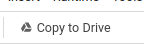

### Submission Instructions:
1. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
2. **Upload the downloaded notebook (.ipynb file) to your repository**.

Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

## Dataset
We will use the geoqueries880 dataset. The original dataset can be found [here](https://www.cs.utexas.edu/users/ml/nldata/geoquery.html), but we will use the version from Data Recombination for Neural Semantic Parsing [(Jia & Liang, 2016)](https://stanford.edu/~robinjia/pdf/jia2016recombination.pdf).
As a semantic parsing dataset, geo880 maps natural language sentences to their 'logical form', which in our case is a query string to be fed to a database.

### Sample training example
natural language sentence:  
`what states border kentucky ?`  
logical form (query string):  
`_answer ( A , ( _state ( A ) , _next_to ( A , B ) , _const ( B , _stateid ( kentucky ) ) ) )`

The result of feeding the query string into the database is called the "execution". For example, the execution of the above query string could be:  
`indiana, ohio, west viginia, virginia, tennessee, missouri, illinois`

Recall from class that mapping between natural sentences and executions (as opposed to logical forms) is known as "weak supervision" (or "light supervision"). For simplicity, we will ignore the execution part, and map between natural sentences and query strings, as in our version of geo880. This is known as "strong supervision" (or, as referred to in the lecture slides, "heavy supervision").

## Initial Setup

In [20]:
from collections import Counter
import math
import os
import random
import time

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# For reproducibility
def set_random_seeds():
    torch.manual_seed(1407)
    random.seed(1411)
    np.random.seed(1710)

## Preprocessing
Before implementing the seq2seq models, we first need to prepare our data. We have already implemented utilities for this end, albeit simple ones.

### Helper utilities

In [22]:
SOS_IDX = 0
SOS_STR = '<SOS>'
EOS_IDX = 1
EOS_STR = '<EOS>'
UNK_IDX = 2
UNK_STR = '<UNK>'

class Vocab:
    def __init__(self, sentences, name, unk_threshold=1):
        self.name = name
        self.unk_threshold = unk_threshold

        self.word_counts = Counter()
        self.i2t = {SOS_IDX: SOS_STR, EOS_IDX: EOS_STR, UNK_IDX: UNK_STR}
        self.t2i = None
        self._parallel_index_mapping = None

        self._count_words(sentences)
        self._create_token_mappings()

    def _count_words(self, sentences):
        for sentence in sentences:
            self.word_counts.update(sentence.split(' '))

    def _create_token_mappings(self):
        n_fixed_tokens = len(self.i2t)
        words_above_threshold = [word for word, count in self.word_counts.items()
                                 if count > self.unk_threshold]
        self.i2t.update(enumerate(words_above_threshold, start=n_fixed_tokens))
        self.t2i = {index: token for token, index in self.i2t.items()}
        self.n_tokens = len(self.t2i)

    def set_parallel_vocab(self, other_vocab):  # only relevant for the copying model

        parallel_index_mapping = {}
        for other_token in other_vocab.t2i:
            if other_token in self.t2i:
                parallel_index_mapping[other_vocab.t2i[other_token]] = self.t2i[other_token]
        self._parallel_index_mapping = parallel_index_mapping

    def get_index_from_parallel_index(self, parallel_index):  # for use with the copying model
        """
        given an index `parallel_index` from a another vocab, returns the this vocab's index of the
        corresponding token.

        For example, if vocab_logical has the token 'kentucky' mapped to index 10, and vocab_natural
        has the token kentucky mapped to index 20, then if self=vocab_logical, we get
        get_index_from_parallel_index(20) returns 10.

        This method should only be used after a call to set_parallel_vocab was
        previously made.
        """
        return self._parallel_index_mapping.get(parallel_index, UNK_IDX)

    def sentence_to_tensor(self, sentence):
        words = sentence.split(' ')
        indices = [self.t2i.get(word, self.t2i[UNK_STR]) for word in words]
        indices.append(self.t2i[EOS_STR])
        return torch.tensor(indices, dtype=torch.long, device=device).view(-1, 1)

In [23]:
def _load_sentence_pairs(path):
    with open(path) as f:
        lines = f.read().strip().split('\n')
    pairs = [[s for s in l.split('\t')] for l in lines]
    return pairs


def _create_vocabs(pairs, unk_threshold=1):
    print("Creating vocabularies...")
    natural_sentences, logical_sentences = zip(*pairs)

    vocab_natural = Vocab(natural_sentences, 'natural', unk_threshold)
    vocab_logical = Vocab(logical_sentences, 'logical', unk_threshold)

    print(f'# natural tokens: {vocab_natural.n_tokens}')
    print(f'# logical tokens: {vocab_logical.n_tokens}')

    return vocab_natural, vocab_logical


def load_data(train_path, dev_path):
    train_sentences = _load_sentence_pairs(train_path)

    vocab_natural, vocab_logical = _create_vocabs(train_sentences)

    dev_sentences = _load_sentence_pairs(dev_path)

    return train_sentences, dev_sentences, vocab_natural, vocab_logical

### Loading the data

In [24]:
!wget https://raw.githubusercontent.com/tau-nlp-course/NLP_HW4/master/data/geo880_dev100.tsv
!wget https://raw.githubusercontent.com/tau-nlp-course/NLP_HW4/master/data/geo880_train500.tsv
ROOT_DIR = '/content/'
TRAIN_SET_PATH = os.path.join(ROOT_DIR, "geo880_train500.tsv")
DEV_SET_PATH = os.path.join(ROOT_DIR, "geo880_dev100.tsv")


train_sentences, dev_sentences, vocab_natural, vocab_logical = load_data(TRAIN_SET_PATH, DEV_SET_PATH)

--2021-12-30 07:11:40--  https://raw.githubusercontent.com/tau-nlp-course/NLP_HW4/master/data/geo880_dev100.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14596 (14K) [text/plain]
Saving to: ‘geo880_dev100.tsv.1’

geo880_dev100.tsv.1 100%[===================>]  14.25K  --.-KB/s    in 0.001s  

2021-12-30 07:11:40 (24.8 MB/s) - ‘geo880_dev100.tsv.1’ saved [14596/14596]

--2021-12-30 07:11:40--  https://raw.githubusercontent.com/tau-nlp-course/NLP_HW4/master/data/geo880_train500.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

Below is a random example from `train_sentences` and `dev_sentences`:

In [25]:
print(f'training example:\n{random.choice(train_sentences)}')
print()
print(f'dev example:\n{random.choice(dev_sentences)}')

training example:
['what is the capital of vermont ?', '_answer ( A , ( _capital ( A ) , _loc ( A , B ) , _const ( B , _stateid ( vermont ) ) ) )']

dev example:
['which state has the red river ?', '_answer ( A , ( _state ( A ) , _loc ( B , A ) , _const ( B , _riverid ( red ) ) , _river ( B ) ) )']


As you can see, each example is a list of length 2 where the first element is a natural language sentence and the second element is its corresponding query string. In both sentences, all words are separated by a space.

The `Vocab` objects, `vocab_natural` and `vocab_logical`, each represent a vocabulary of tokens from the corresponding 'natural language' and 'query string' domains. When creating the vocabularies, each word that occurrs less than 2 times (`unk_threshold=1`) in the training set is considered an unknown (`<UNK>`) token. Note that even though there are shared tokens between them, each vocabulary was created based on a single domain (natural/query).

### 'Special' strings in the logical domain
observe the query string from the following training example:

In [26]:
print(train_sentences[24])

['what is the highest elevation in south carolina ?', "_answer ( A , _highest ( A , ( _place ( A ) , _loc ( A , B ) , _const ( B , _stateid ( ' south carolina ' ) ) ) ) )"]


Note that ` ' south carolina ' ` could be seen as a single logical token, just like `kentucky`. However, in our simple tokenization scheme, this word is tokenized into 4 different tokens: `'`, `south`, `carolina` and `'`. This hurts performance, but will probably make the implementation in later stages easier.

## Simple Seq2seq Model
In this part we will implement a simple encoder-decoder model, similar to v1.0 from class. In addition to the class slides, a good reference material for seq2seq models is [Jay Alammar](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/). It contains helpful animations explaining our v1.0 seq2seq model, in addition to the v2.0 model (attention) that we will implement later.

### Encoder
Our encoder is very simple, using a [GRU](https://pytorch.org/docs/stable/nn.html#gru) to encode the natural language sentence. Note that the `input_size` parameter of the `GRU` is not the length of the input, but the dimension of the input vector at every timestep.

### Question 1.1
Implement the `forward` method of `EncoderRNN`.  
To implement, just pass the embedded input through the GRU and return the output and the hidden state. You can use the class slides and Jay Alammar as a reference.

In [67]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, vocab):
        super().__init__()
        self.hidden_size = hidden_size
        self.vocab = vocab

        self.embedding = nn.Embedding(self.vocab.n_tokens, hidden_size)
        self.gru = nn.GRU(input_size, hidden_size)

    def forward(self, input, h_0):
        ### YOUR CODE HERE
        emb = self.embedding(input)
        output, h_0 = self.gru(emb, h_0)
        ### --------------
        return output, h_0

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Simple decoder
Unlike the encoder, our decoder uses a [GRUCell](https://pytorch.org/docs/stable/nn.html#grucell) and not a GRU. This is because while decoding, we want to be able to control the input of the decoder in each timestep (e.g. ["teacher forcing"](https://towardsdatascience.com/what-is-teacher-forcing-3da6217fed1c)).  
In addition, there are two additional parameter matrices in `DecoderSimple`.  
The first is `W_p`, and is used to project the last hidden state of the encoder to the decoder space, as the their hidden dimensions are not necessarily equal (albeit in our case they _are_ equal).  
The second is `W_s`, and is used as $W^{(s)}$ from class.  
You can ignore the `uses_copying` attribute, as it will only be relevant in question 3.

### Question 1.2
Implement the `forward` method of `DecoderSimple`.  
 You can use the class slides and Jay Alammar as a reference.  
Don't forget to address the `evaluation_mode` parameter, as the input to `GRUCell` could depend on whether we are training or evaluating. It is your choice if and how to use teacher forcing during training, but at least some usage of teacher forcing is highly recommended.

In [68]:
class DecoderSimple(nn.Module):
    def __init__(self, input_size, hidden_size, vocab, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.vocab = vocab
        self.output_size = self.vocab.n_tokens

        self.uses_copying = False

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        # for projecting the last hidden state of the encoder to the decoder space,
        # as the first decoder hidden state, in case the two dimensions don't match
        self.W_p = nn.Linear(enc_hidden_size, hidden_size)

        self.gru_cell = nn.GRUCell(self.input_size, self.hidden_size)

        # for output
        self.W_s = nn.Linear(self.hidden_size, self.output_size)

    #You can stop once you reach the EOS token or we have reached max_decoding_steps
    def forward(self, targets, h, evaluation_mode=False, max_decoding_steps=200, **kwargs):
        
        ### YOUR CODE HERE
        output_list = []
        h = self.W_p(h).view(1, -1)
        output = 0
        i = 0
        while output != 1 and i < max_decoding_steps:
          h = self.gru_cell(self.embedding.weight[output].view(1,-1), h)
          out_probs = self.W_s(h)
          output_list.append(out_probs)
          if not evaluation_mode:
            output = targets[i]
          else:
            output = torch.argmax(out_probs)
          i += 1
        outputs = torch.stack(output_list).view(len(output_list), -1)
        ### --------------
        return outputs

## Training
To simplify debugging, we always use a batch size of 1. Note that just as our simple tokenization scheme, using a batch size of 1 (where we could probably train all examples in one batch) will hurt performance.

During training, we pass the tokenized natural sentence through the encoder, and pass the final encoder hidden state (as well as additional arguments in later, more complex, models) to the decoder. Then, we use the decoder output the calculate the loss with a `criterion`, and perform backpropagation.

Until question 3, you can ignore the `if dec.uses_copying:` condition and assume it is always false. You will implement this part in question 3.2.

In [69]:
def train_single_example(input_tensor, target_tensor, enc, dec,
                         enc_optimizer, dec_optimizer, criterion):
    encoder_hidden_first = enc.init_hidden()

    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs, encoder_h_m = enc(input_tensor, encoder_hidden_first)

    decoder_hidden = encoder_h_m

    decoder_outputs = dec(target_tensor, decoder_hidden, enc_input=input_tensor, enc_outputs=encoder_outputs)

    if dec.uses_copying:
        ### YOUR CODE HERE
        raise NotImplementedError
        ### --------------
    else:
        criterion_target = target_tensor.view(-1)
    loss = criterion(decoder_outputs, criterion_target)

    loss.backward()

    enc_optimizer.step()
    dec_optimizer.step()

    return loss.item() / target_length

After each epoch, we can save the current model in the `parameters/` directory using the `save` parameter in `train`.


In [30]:
!mkdir -p /content/parameters
PARAMETERS_DIR = os.path.join(ROOT_DIR, 'parameters')

def save_model(enc, dec, epoch, postfix=''):
    torch.save(enc, os.path.join(PARAMETERS_DIR, f'enc_{epoch}{postfix}.pt'))
    torch.save(dec, os.path.join(PARAMETERS_DIR, f'dec_{epoch}{postfix}.pt'))

Simple utility functions for printing the status of the training:

In [31]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return '%s (%s)' % (asMinutes(s), asMinutes(rs))

When training, we can use the `patience` parameter to stop the training if our results on the dev set didn't improve for `patience` number of epoch. The default, -1, means training for `n_epochs` regardless of the results.

In [32]:
def train(n_epochs, train_set, dev_set, enc, dec, criterion,
          patience=-1, save=True, print_sentences=False):
    start = time.time()

    train_accuracies = []
    losses = []
    epoch_loss = 0  # Reset every epoch

    dev_accuracies = []
    best_dev_accuracy = 0
    epochs_without_improvement = 0  # for early stopping (patience)

    encoder_optimizer = optim.Adam(enc.parameters())
    decoder_optimizer = optim.Adam(dec.parameters())

    for epoch in range(1, n_epochs + 1):
        random.shuffle(train_set)

        for natural_string, logical_string in train_set:
            input_tensor = enc.vocab.sentence_to_tensor(natural_string)
            target_tensor = dec.vocab.sentence_to_tensor(logical_string)

            loss = train_single_example(input_tensor, target_tensor, enc, dec,
                                        encoder_optimizer, decoder_optimizer, criterion)
            epoch_loss += loss

        average_loss = epoch_loss / len(train_set)
        losses.append(average_loss)
        epoch_loss = 0

        train_accuracy = evaluate(train_set, enc, dec, print_sentences)
        train_accuracies.append(train_accuracy)

        dev_accuracy = evaluate(dev_set, enc, dec, print_sentences)
        dev_accuracies.append(dev_accuracy)

        print(f'Epoch #{epoch}:\n'
              f'Loss: {average_loss:.4f}\n'
              f'Train accuracy: {train_accuracy:.3f}\n'
              f'Dev accuracy: {dev_accuracy:.3f}\n'
              f'Time elapsed (remaining): {timeSince(start, epoch / n_epochs)}')

        if save:
            save_model(enc, dec, epoch)

        if dev_accuracy > best_dev_accuracy:
            best_dev_accuracy = dev_accuracy
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement == patience:
                print(f'Training didn\'t improve for {patience} epochs\n'
                      f'Stopped Training at epoch {epoch}\n'
                      f'Best epoch: {epoch - patience}')
                break

    return losses, train_accuracies, dev_accuracies

### Plotting the accuracies
Using the return values of `train`, we can use `plot_accuracies` to create a plot of our performance on the train and dev sets during training.

In [33]:
!mkdir -p /content/figures
FIGURES_DIR = os.path.join(ROOT_DIR, 'figures')

def plot_accuracies(train_accs, dev_accs, model_name):

    plt.clf()
    plt.title(model_name)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.plot(train_accs, label='train')
    plt.plot(dev_accs, label='dev')

    plt.xticks(range(len(train_accs)), range(1, len(train_accs) + 1))
    plt.yticks(np.around(np.linspace(0.0, 1.0, num=11), decimals=1))

    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(FIGURES_DIR, f'{model_name}.png'))

    plt.show()

## Evaluation

When evaluating, we perform a procedure similar to training, with the following differences:  
* We do not perform backpropagation or compute gradients.
* At each timestep of the decoder, the input is determined by the `if evaluation_mode:` clause of the `forward` method in the previous timestep (recall Question 1.2). In class, we saw using the most probable token (argmax) from the output of the previous timestep as an input of the current timestep.
* The outputs of the decoder, containing indices of the predicted tokens, are transformed into strings to create the predicted query string.

Our evaluation metric is "exact match": a prediction is correct only if it is identical to the target query string.

Until question 3, you can ignore the `if dec.uses_copying:` condition and assume it is always false. You will implement this part in question 3.3.

In [34]:
def evaluate(sentences, enc, dec, print_sentences=True):
    total = 0
    correct = 0

    with torch.no_grad():
        for pair in sentences:
            input_sentence, target_sentence = pair
            input_tensor = enc.vocab.sentence_to_tensor(input_sentence)
            target_tensor = dec.vocab.sentence_to_tensor(target_sentence)

            encoder_hidden_first = enc.init_hidden()

            encoder_outputs, encoder_h_m = enc(input_tensor, encoder_hidden_first)

            decoder_hidden = encoder_h_m

            decoder_outputs = dec(target_tensor, decoder_hidden,
                                  enc_outputs=encoder_outputs, enc_input=input_tensor,
                                  evaluation_mode=True)
            decoded_indices = torch.argmax(decoder_outputs, dim=1)

            if dec.uses_copying:
                
                ### YOUR CODE HERE
                raise NotImplementedError
                ### --------------

            else:
                decoded_tokens = [dec.vocab.i2t[idx.item()] for idx in decoded_indices]

            decoded_sentence = ' '.join(decoded_tokens[:-1])  # ignore the EOS token

            if decoded_sentence == target_sentence:
                correct += 1
            total += 1

            if print_sentences:
                print(f'input:    {input_sentence}')
                print(f'expected: {target_sentence}')
                print(f'result:   {decoded_sentence}')

    accuracy = correct / total
    return accuracy

### Testing Question 1
To test your implementation of the simple model, you can run the following two cells. **Make sure to use the GPU and not the CPU: `Runtime`->`Change runtime type`->`Hardware accelerator`->`GPU`**.  

Note that we expect a dev accuracy of at least 30 sometime until epoch 40 (could be a lot earlier). Your code will be run with several initial seeds, and therefore the 30 dev accuracy is expected on average.  
Use the `nn.CrossEntropyLoss` criterion.

To compare implementations during debugging, you can use the `set_random_seeds()` function.

**Add the output figure, `ROOT/figures/simple_decoder.png`, to your written solution pdf file!** 

In [35]:
# general settings, to be used with all the models
enc_input_size = 256
enc_hidden_size = 256

dec_input_size = 256
dec_hidden_size = 256

n_epochs = 40

Epoch #1:
Loss: 0.0243
Train accuracy: 0.002
Dev accuracy: 0.000
Time elapsed (remaining): 0m 34s (22m 21s)
Epoch #2:
Loss: 0.0134
Train accuracy: 0.004
Dev accuracy: 0.000
Time elapsed (remaining): 1m 12s (22m 48s)
Epoch #3:
Loss: 0.0103
Train accuracy: 0.026
Dev accuracy: 0.020
Time elapsed (remaining): 1m 47s (22m 2s)
Epoch #4:
Loss: 0.0086
Train accuracy: 0.038
Dev accuracy: 0.030
Time elapsed (remaining): 2m 22s (21m 22s)
Epoch #5:
Loss: 0.0075
Train accuracy: 0.070
Dev accuracy: 0.050
Time elapsed (remaining): 2m 57s (20m 42s)
Epoch #6:
Loss: 0.0065
Train accuracy: 0.094
Dev accuracy: 0.040
Time elapsed (remaining): 3m 32s (20m 4s)
Epoch #7:
Loss: 0.0063
Train accuracy: 0.128
Dev accuracy: 0.060
Time elapsed (remaining): 4m 7s (19m 25s)
Epoch #8:
Loss: 0.0054
Train accuracy: 0.104
Dev accuracy: 0.050
Time elapsed (remaining): 4m 42s (18m 48s)
Epoch #9:
Loss: 0.0050
Train accuracy: 0.138
Dev accuracy: 0.100
Time elapsed (remaining): 5m 17s (18m 13s)
Epoch #10:
Loss: 0.0045
Train a

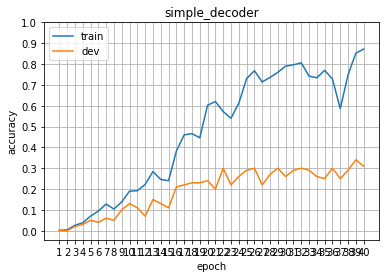

In [65]:
# print('--- Training Simple Model ---')
enc1 = EncoderRNN(enc_input_size, enc_hidden_size, vocab_natural).to(device)
dec1 = DecoderSimple(dec_input_size, dec_hidden_size, vocab_logical).to(device)
criterion1 = nn.CrossEntropyLoss()

losses1, train_accs1, dev_accs1 = train(n_epochs, train_sentences, dev_sentences,
                                        enc1, dec1, criterion1)
plot_accuracies(train_accs1, dev_accs1, 'simple_decoder')

## Improving the Simple Model

We can improve this simple model in various ways, many of them are very simple:  

* Using a bidirectional GRU in the encoder instead of a unidirectional one.
* Using stack RNNs.
* Using pretrained embeddings, such as GloVe, Instead of our randomly initialized embeddings.
* Using [dropout](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/). It is especially beneficial with small datasets, like ours. 
* Decoding with beam search.
* Larger batch size and better tokenization, as we already mentioned.

In this assignment, we won't use any of those. Instead, we will implement an attention mechanism as we saw in class.

## Attention Seq2seq Model
In this part we will introduce attention to our model, and implement a model like the one we saw in class. In this v2.0 model we will use the same encoder, so we'll just implement an improved decoder.

### Question 2
Implement the `forward` method of `DecoderAttention`. You can copy parts of your code from the `forward` method of `DecoderSimple`.
 Note that there is no single canonical implementation of attention in seq2seq. You can take inspiration from the class slides, from Jay Alammar, or from any source of your choosing. But you have to utilize the encoder outputs at each timestep of the decoder.
 
Don't forget to address the `evaluation_mode` parameter, as the input to `GRUCell` could depend on whether we are training or evaluating. It is your choice if and how to use teacher forcing during training, but at least some usage of teacher forcing is highly recommended.

In [ ]:
class DecoderAttention(DecoderSimple):
    def __init__(self, input_size, hidden_size, vocab, enc_hidden_size, **kwargs):
        super().__init__(input_size, hidden_size, vocab, **kwargs)

        # for attention
        self.enc_hidden_size = enc_hidden_size
        self.W_a = nn.Linear(self.enc_hidden_size, self.hidden_size)

        # for output
        self.W_s = nn.Linear(self.hidden_size + self.enc_hidden_size, self.output_size)

    def forward(self, targets, h, enc_outputs, evaluation_mode=False,max_decoding_steps=200, **kwargs):

        ### YOUR CODE HERE
        raise NotImplementedError
        ### --------------
        return outputs

### Testing Question 2
To test your implementation of the attention model, you can run the following cell. Note that we expect a dev accuracy of at least 40 sometime until epoch 40 (could be a lot earlier). Your code will be run with several initial seeds, and therefore the 40 dev accuracy is expected on average.  
Use the `nn.CrossEntropyLoss` criterion.

To compare implementations during debugging, you can use the `set_random_seeds()` function.

**Add the output figure, `ROOT/figures/attention_decoder.png`, to your written solution pdf file!** 

In [ ]:
print('--- Training Attention Model ---')
enc2 = EncoderRNN(enc_input_size, enc_hidden_size, vocab_natural).to(device)
dec2 = DecoderAttention(dec_input_size, dec_hidden_size, vocab_logical, enc_hidden_size).to(device)
criterion2 = nn.CrossEntropyLoss()

losses2, train_accs2, dev_accs2 = train(n_epochs, train_sentences, dev_sentences,
                                        enc2, dec2, criterion2)
plot_accuracies(train_accs2, dev_accs2, 'attention_decoder')

## Attention Seq2seq Model with Copying
As we saw in class, we can still improve upon the attention model. This can be done by adding a 'copying' mechanism, which could be viewed as a variant on pointer networks ([Vinyals et al, 2015](https://arxiv.org/abs/1506.03134)). Before implementing this model, we suggest that you review slides [52-61](https://www.cs.tau.ac.il/~joberant/teaching/nlp_fall_2019_2020/files/08_seq2seq.pdf#page=52) from the seq2seq lecture slides.

As with the regular attention model, we will use the same encoder, and improve upon the decoder.

### Question 3.1
Implement the `forward` method of `DecoderAttentionWithCopying`. You can copy parts of your code from the `forward` method of `DecoderAttention`.
 As in the regular attention model and even more so, there is no single canonical implementation of attention with copying in seq2seq. You can take inspiration from the class slides, from section 3.2 of Data Recombination for Neural Semantic Parsing [(Jia & Liang, 2016)](https://stanford.edu/~robinjia/pdf/jia2016recombination.pdf), or from any source of your choosing.
 
Unlike the previous two decoders, here you can also add define additional weights/parameters in the `__init__`, in case you find it beneficial to your model.

In addition, feel free to use `get_index_from_parallel_index` from your vocab object. You can assume the call `vocab_logical.set_parallel_vocab(vocab_natural)` was already made.


Don't forget to address the `evaluation_mode` parameter, as the input to `GRUCell` could depend on whether we are training or evaluating. It is your choice if and how to use teacher forcing during training, but at least some usage of teacher forcing is highly recommended.

In [ ]:
class DecoderAttentionWithCopying(DecoderAttention):
    def __init__(self, input_size, hidden_size, vocab, enc_hidden_size, **kwargs):
        super().__init__(input_size, hidden_size, vocab, enc_hidden_size, **kwargs)

        self.uses_copying = True

        # PLACE TO ADD ADDITIONAL WEIGHTS (optional)

        # ------------------------------------------

    def forward(self, targets, h, enc_outputs, enc_input, evaluation_mode=False, max_decoding_steps=200):

        ### YOUR CODE HERE
        raise NotImplementedError
        ### --------------
        return outputs

### Question 3.2
In addition to the new decoder, a change in `train_single_example` is also required, as now `criterion_target` should not be composed solely from `target_tensor`. Also, note that with `DecoderAttentionWithCopying` we use the [`BCEWithLogitsLoss`](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss) loss criterion (see later in notebook for details).

Implement the `if dec.uses_copying:` clause of `train_single_example`.

In general this part should help the loss function (`criterion`) understand what tokens from the input (natural sentence) are desirable for copying (in addition to the actual target token from the query string). This is done by defining `criterion_target` accordingly.



### Question 3.3

Finally, we need add code in `evaluate`. Implement the `if dec.uses_copying:` clause of `evaluate`.

This code should enable the model to:
* Decode tokens from the input natural sentence (as well as from the query string, as was done until now).
* Copy input tokens that do not exist in our vocabulary.

This question is quite open ended, so feel free to experiment, as long as your code follows the two guidelines above.

For simplicity, we added below a set of all the words that are entities (i.e worth considering copying) and occur in both the natural sentences and the the query strings. This set is based on the words from the training set and the dev set, as well as from the hidden test set.

You may add additional functions/code to be used in the `if dec.uses_copying:` clause of `evaluate` if you wish.



In [ ]:
# in practice, entities are probably decduced by some pretrained NER model
all_entities = {
    'rochester', 'kentucky', 'potomac', 'georgia', 'boulder', 'missouri', 'mississippi',
    'sacramento', 'island', 'mount', 'houston', 'guadalupe', 'baton', 'north', 'spokane', 'salem',
    'alabama', 'utah', 'erie', 'scotts', 'death', 'springfield', 'idaho', 'ohio', 'francisco',
    'valley', 'jose', 'rio', 'new', 'chicago', 'florida', 'diego', 'indiana', 'detroit', 'montana',
    'seattle', 'south', 'wyoming', 'texas', 'alaska', 'dakota', 'orleans', 'minnesota', 'riverside',
    'delaware', 'plano', 'pittsburgh', 'hampshire', 'california', 'flint', 'nevada', 'west',
    'massachusetts', 'york', 'illinois', 'me', 'oregon', 'mckinley', 'tucson', 'chattahoochee',
    'des', 'arizona', 'michigan', 'maine', 'maryland', 'rhode', 'kalamazoo', 'tennessee', 'hawaii',
    'virginia', 'salt', 'atlanta', 'austin', 'miami', 'antonio', 'carolina', 'san', 'durham',
    'jersey', 'colorado', 'indianapolis', 'dover', 'vermont', 'albany', 'rouge', 'kansas', 'usa',
    'grande', 'red', 'pennsylvania', 'nebraska', 'wayne', 'washington', 'tempe', 'mexico',
    'montgomery', 'platte', 'whitney', 'arkansas', 'fort', 'oklahoma', 'boston', 'dallas',
    'portland', 'louisiana', 'wisconsin', 'minneapolis', 'denver', 'peak', 'moines', 'dc',
    'columbus', 'iowa'
}

def is_entity(token):
    return token in all_entities


# PLACE TO ADD OPTIONAL ADDITIONAL CODE TO BE USED IN THE COPYING CLAUSE OF `evaluate`


# ------------------------------------------------------------------------------------


### Testing Question 3
To test your implementation of the attention model with copying, you can run the following cell. Note that we expect a dev accuracy of at least 4 sometime until epoch 40 (could be a lot earlier), **as well as at least of couple of points better than the regular attention model**. Your code will be run with several initial seeds, and therefore the 40 dev accuracy and the slight improvement over the regular attention model are expected on average.  
Use the `BCEWithLogitsLoss` criterion in the following way: Concat the logits for the copy scores and grammar scores and calculate the loss over that tensor.
To compare implementations during debugging, you can use the `set_random_seeds()` function.

**Add the output figure, `ROOT/figures/attention_with_copying_decoder.png`, to your written solution pdf file!** 

In [ ]:
print('--- Training Copying Model ---')
set_random_seeds()
vocab_logical.set_parallel_vocab(vocab_natural)
enc3 = EncoderRNN(enc_input_size, enc_hidden_size, vocab_natural).to(device)
dec3 = DecoderAttentionWithCopying(dec_input_size, dec_hidden_size, vocab_logical, enc_hidden_size).to(device)
criterion3 = nn.BCEWithLogitsLoss()

losses3, train_accs3, dev_accs3 = train(n_epochs, train_sentences, dev_sentences, enc3, dec3, criterion3)
plot_accuracies(train_accs3, dev_accs3, 'attention_with_copying_decoder')


## On Reaching State of the Art Results
In Data Recombination for Neural Semantic Parsing [(Jia & Liang, 2016)](https://stanford.edu/~robinjia/pdf/jia2016recombination.pdf#page=7), the results were much better than our model - 85.0 (and even higher with some additional methods they introduced). A substantial part of this gap could be reduced by applying the rather simple suggestions from the [Improving the Simple Model](https://colab.research.google.com/drive/1LuVweHOfi3qQkipZHTki9cyI_TOcRQyQ#scrollTo=Exq6p6XtXJvH&line=2&uniqifier=1) cell. So when you are confident that your implementation is working, feel free to see how close you can get to these impressive results!


## Previous Student Questions

**Q:**Do we need to use W_p even though the dimensions match? it's stated in the comments: "in case the two dimensions don't match" and in our case they do…

**A:**The point of W_p is to project the decoder state to the encoder state, are you suggesting to use W_s?

**Q:**I mean it says here: as the their hidden dimensions are not necessarily equal (albeit in our case they are equal) i.e. in our case the dimensions are equal, so should we still use W_p for projection?

**A:** Yes

\\
**Q:**What should we do in the case where in the previous step we copied an input word in evaluation mode? we need to pass the previous output as input to the next GRU cell, but it's not necessarily a valid word in the decoder's vocab (throws an error in the embedding layer...) thanks!

**A:**Notice you have 2 vocabularies, vocab_natural and vocab_logical. if idx >= dec.vocab.n_tokens it might be inside vocab_natural then you can check with enc.vocab.i2t to confirm

**Q:**thanks for responding, I'll clarify. Assume in time i we copied the index i > dec.vocab.n_tokens, then idx should be the input for timestamp i+1, when we pass it through the GRU there's an embedding layer: nn.Embedding(self.output_size, self.hidden_size) where idx is out of range.
The question is: assuming that in timestamp i we copy from the input, what should we use as input for i+1? (in evaluation it should be the output from i which is not a valid index for the embedding layer...)

**A:** I suggest you take a look at the get_index_from_parallel_index method of the Vocab class

**Q:** Not sure I fully understand what you mean here. Using get_index_from_parallel_index would yield the same index(UNK) for all words not in the vocab. Does that mean we should not copy an input word if it is not in the output space vocab?

**A:** The model could decide to copy that word, but since it has no embedding for it, it is represented by a "UNK" embedding.

**Q:** Just to clarify I understand you correctly,
1) The decoder would treat all words not in the target vocab the same, i.e that would be equivalent to replacing all such words in enc_input with "UNK" in so far as computing probability by the decoder goes.
2) for actually generating the output sequence, when copying, we would take the original word and not "UNK". correct?

**A:** Yes

















